# Import library

In [3]:
!pip install lion-pytorch

In [4]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transform
import torchvision
import torchvision.models as models
from lion_pytorch import Lion

# 1. Load data

In [5]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_data(base_path):
    # Define the paths
    train_path = os.path.join(base_path, "Train")
    val_path = os.path.join(base_path, "Val")
    test_path = os.path.join(base_path, "Test")

    # Helper function to load files and labels into a DataFrame
    def load_from_folder_to_dataframe(folder_path):
        data = []
        labels = []
        if os.path.exists(folder_path):
            for label in os.listdir(folder_path):
                label_folder = os.path.join(folder_path, label)
                if os.path.isdir(label_folder):
                    files = glob.glob(os.path.join(label_folder, "*"))
                    data.extend(files)
                    labels.extend([label] * len(files))
        return pd.DataFrame({"path": data, "label": labels})

    # Load train and val datasets
    train_df = load_from_folder_to_dataframe(train_path)
    val_df = load_from_folder_to_dataframe(val_path)
    test_df = load_from_folder_to_dataframe(test_path)

    # Encode labels into integers
    encoder = LabelEncoder()
    if not train_df.empty:
        train_df["label"] = encoder.fit_transform(train_df["label"])
    if not val_df.empty:
        val_df["label"] = encoder.transform(val_df["label"])
    if not test_df.empty:
        test_df["label"] = encoder.transform(test_df["label"])

    return train_df, val_df, test_df


# Example usage
base_path = "/kaggle/input/d/methylbenzel/gender-classification-data/Dataset"
data_train, data_val,data_test = load_data(base_path)

# # Print dataset information
# print("Number of training samples:", len(data_train))
# print("Number of validation samples:", len(data_val))
# print("Number of test samples:", len(data_test))
# print("Example training labels:", label_train[:5])


# 2. Data Loader and Custom Data Class

In [6]:
from PIL import Image
import os
import torch
from sklearn.model_selection import train_test_split

# define a data class
class ClassificationDataset:
    def __init__(self, data, data_path, transform, training=True):
        """Define the dataset for classification problems

        Args:
            data ([dataframe]): [a dataframe that contain 2 columns: image name and label]
            data_path ([str]): [path/to/folder that contains image file]
            transform : [augmentation methods and transformation of images]
            training (bool, optional): []. Defaults to True.
        """
        self.data = data
        self.imgs = data["path"].unique().tolist()
        self.data_path = data_path
        self.training = training
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_path, self.data.iloc[idx, 0]))
        label = self.data.iloc[idx, 1]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)


def make_loader(dataset, train_batch_size, validation_split=0.2):
    """make dataloader for pytorch training

    Args:
        dataset ([object]): [the dataset object]
        train_batch_size ([int]): [training batch size]
        validation_split (float, optional): [validation ratio]. Defaults to 0.2.

    Returns:
        [type]: [description]
    """
    # number of samples in train and test set
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    # create train_loader
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=train_batch_size, shuffle=True,
    )
    # create test_loader
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False,)
    return train_loader, test_loader


def data_split(data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        data, data["label"], test_size=test_size, stratify = data.iloc[:,1]
    )
    return x_train, x_test, y_train, y_test

# 3. Define Metric and Optimizers Loss Function 

In [7]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict


In [8]:
train_metrics = Metrics(["accuracy_score","f1_score"])
val_metrics = Metrics(["accuracy_score","f1_score"])

# 4. Defining the Training Function

In [9]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor), target.type(torch.LongTensor))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.type(torch.FloatTensor).to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.argmax(output, axis=1).tolist()
            labels = target.tolist()
            all_labels.extend(labels)
            all_preds.extend(preds)
            loss = criterion(output, target)

            # update-average-validation-loss
            valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

In [10]:
import logging
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

# Initialize Weights & Biases (wandb)
wandb.init(project="gender_classification", name="training_run")

print("Begin training process")

def train(model, train_loader, val_loader, device, optimizer, criterion, train_metrics, val_metrics, num_epoch,best_val_acc = 0):
    best_val_acc = best_val_acc

    # Lists to store training and validation metrics for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for i in tqdm(range(0, num_epoch)):
        loss, val_loss, train_result, val_result = train_one_epoch(
            model,
            train_loader,
            val_loader,
            device,
            optimizer,
            criterion,
            train_metrics,
            val_metrics,
        )
        
        scheduler.step(val_loss)

        # Append metrics for plotting
        train_losses.append(loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_result.get("accuracy_score", 0))
        val_accuracies.append(val_result.get("accuracy_score", 0))

        # Log training metrics
        print(
            "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
                i + 1, num_epoch, loss
            )
        )
        print(train_result)
        print(
            " \n Validation loss : {} - Other validation metrics:".format(val_loss)
        )
        print(val_result)
        print("\n")
        
        # Log metrics to wandb
        wandb.log({
            "epoch": i + 1,
            "train_loss": loss,
            "val_loss": val_loss,
            "train_accuracy": train_result.get("accuracy_score", 0),
            "val_accuracy": val_result.get("accuracy_score", 0),
        })
        
        # Save model if validation accuracy improves
        if best_val_acc < float(val_result["accuracy_score"]):
            print(
                "Validation accuracy= " +
                str(val_result["accuracy_score"]) +
                " ===> Save best epoch"
            )
            best_val_acc = val_result["accuracy_score"]
            torch.save(
                model,
                "./" + "best.pt",
            )
        else:
            print(
                "Validation accuracy= " + str(val_result["accuracy_score"]) + " ===> No saving"
            )
            continue

    # Plot training and validation metrics
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, num_epoch + 1), val_losses, label="Validation Loss", marker="o")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracies, label="Training Accuracy", marker="o")
    plt.plot(range(1, num_epoch + 1), val_accuracies, label="Validation Accuracy", marker="o")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Save and display the plot
    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

    # Finish wandb run
    wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Begin training process


# 5.Config

In [11]:
batch_size = 128
num_epoch = 30
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6.  First Approach : using Resnet 18 model without Agument Data Technical

## 6.1 Don't you Agument Data Technical

In [10]:
import torchvision.transforms as transform
import torchvision
batch_size = 128
transformer = transform.Compose([
                           transform.Resize((224, 224)),
                           transform.ToTensor(),])

trainset = ClassificationDataset(data_train,data_path = "",transform=transformer, training=False)
train_loader,_ = make_loader(trainset, train_batch_size=batch_size, validation_split=0.0)
valset = ClassificationDataset(data_val,data_path = "",transform=transformer, training=False)
val_loader,_ = make_loader(valset, train_batch_size=batch_size, validation_split=0.0)

In [12]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch import nn

def load_model_resnet18(pretrained=False, device = "cpu"):
    # Load a pre-trained ResNet model
    model = models.resnet18(pretrained=pretrained).cuda()  # Example: ResNet-18
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Adjust output layer for the number of classes
    model = model.to(device)

    return model


Training and Validating  model resnet-18

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  3%|▎         | 1/30 [01:37<47:07, 97.50s/it]

Epoch 1 / 30 
 Training loss: 0.40832671332359316 - Other training metrics: 
{'accuracy_score': 0.798625, 'f1_score': 0.7986240906619093}
 
 Validation loss : 0.2229765887260437 - Other validation metrics:
{'accuracy_score': 0.909, 'f1_score': 0.908999180992629}


Validation accuracy= 0.909 ===> Save best epoch


  7%|▋         | 2/30 [02:15<29:15, 62.69s/it]

Epoch 2 / 30 
 Training loss: 0.15122213995456696 - Other training metrics: 
{'accuracy_score': 0.941125, 'f1_score': 0.9411198249846178}
 
 Validation loss : 0.20104788017272948 - Other validation metrics:
{'accuracy_score': 0.928, 'f1_score': 0.9278727675619793}


Validation accuracy= 0.928 ===> Save best epoch


 10%|█         | 3/30 [02:51<22:45, 50.58s/it]

Epoch 3 / 30 
 Training loss: 0.08842686706781387 - Other training metrics: 
{'accuracy_score': 0.967, 'f1_score': 0.966999001719802}
 
 Validation loss : 0.13856616020202636 - Other validation metrics:
{'accuracy_score': 0.952, 'f1_score': 0.9519844429595189}


Validation accuracy= 0.952 ===> Save best epoch


 13%|█▎        | 4/30 [03:27<19:23, 44.76s/it]

Epoch 4 / 30 
 Training loss: 0.05722275137901306 - Other training metrics: 
{'accuracy_score': 0.978125, 'f1_score': 0.9781248766106322}
 
 Validation loss : 0.14297045987844467 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.9609934078859327}


Validation accuracy= 0.961 ===> Save best epoch


 17%|█▋        | 5/30 [04:03<17:15, 41.43s/it]

Epoch 5 / 30 
 Training loss: 0.03691830410063267 - Other training metrics: 
{'accuracy_score': 0.987, 'f1_score': 0.9869999926874959}
 
 Validation loss : 0.16603382909297942 - Other validation metrics:
{'accuracy_score': 0.952, 'f1_score': 0.951995199519952}


Validation accuracy= 0.952 ===> No saving


 20%|██        | 6/30 [04:36<15:29, 38.71s/it]

Epoch 6 / 30 
 Training loss: 0.034866593785583974 - Other training metrics: 
{'accuracy_score': 0.986375, 'f1_score': 0.9863749895683513}
 
 Validation loss : 0.14815114152431488 - Other validation metrics:
{'accuracy_score': 0.957, 'f1_score': 0.9569947963703609}


Validation accuracy= 0.957 ===> No saving


 23%|██▎       | 7/30 [05:09<14:07, 36.84s/it]

Epoch 7 / 30 
 Training loss: 0.019083746500313283 - Other training metrics: 
{'accuracy_score': 0.993125, 'f1_score': 0.9931249998925782}
 
 Validation loss : 0.13836074441671373 - Other validation metrics:
{'accuracy_score': 0.956, 'f1_score': 0.955995599559956}


Validation accuracy= 0.956 ===> No saving


 27%|██▋       | 8/30 [05:42<13:00, 35.49s/it]

Epoch 8 / 30 
 Training loss: 0.008629094485891983 - Other training metrics: 
{'accuracy_score': 0.997625, 'f1_score': 0.9976249990722652}
 
 Validation loss : 0.17710833245515822 - Other validation metrics:
{'accuracy_score': 0.957, 'f1_score': 0.9569965167178541}


Validation accuracy= 0.957 ===> No saving


 30%|███       | 9/30 [06:15<12:12, 34.89s/it]

Epoch 9 / 30 
 Training loss: 0.008069400060223416 - Other training metrics: 
{'accuracy_score': 0.997, 'f1_score': 0.9969999983124991}
 
 Validation loss : 0.18970676398277284 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.9609999609999609}


Validation accuracy= 0.961 ===> No saving


 33%|███▎      | 10/30 [06:48<11:25, 34.26s/it]

Epoch 10 / 30 
 Training loss: 0.008509638306917623 - Other training metrics: 
{'accuracy_score': 0.99675, 'f1_score': 0.99675}
 
 Validation loss : 0.20786949861049653 - Other validation metrics:
{'accuracy_score': 0.952, 'f1_score': 0.952}


Validation accuracy= 0.952 ===> No saving


 37%|███▋      | 11/30 [07:21<10:41, 33.78s/it]

Epoch 11 / 30 
 Training loss: 0.008468210113467649 - Other training metrics: 
{'accuracy_score': 0.997375, 'f1_score': 0.997374998974609}
 
 Validation loss : 0.20164648842811583 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.957998487945566}


Validation accuracy= 0.958 ===> No saving


 40%|████      | 12/30 [07:54<10:01, 33.44s/it]

Epoch 12 / 30 
 Training loss: 0.003996858644997701 - Other training metrics: 
{'accuracy_score': 0.99875, 'f1_score': 0.99875}
 
 Validation loss : 0.19722376441955566 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.9609990249756244}


Validation accuracy= 0.961 ===> No saving


 43%|████▎     | 13/30 [08:27<09:26, 33.30s/it]

Epoch 13 / 30 
 Training loss: 0.0017074505519121886 - Other training metrics: 
{'accuracy_score': 0.9995, 'f1_score': 0.9995}
 
 Validation loss : 0.21701085126399994 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.9609999609999609}


Validation accuracy= 0.961 ===> No saving


 47%|████▋     | 14/30 [09:00<08:50, 33.19s/it]

Epoch 14 / 30 
 Training loss: 0.0012483604970329907 - Other training metrics: 
{'accuracy_score': 0.999625, 'f1_score': 0.9996249999941407}
 
 Validation loss : 0.22396187937259673 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.960999648996841}


Validation accuracy= 0.961 ===> No saving


 50%|█████     | 15/30 [09:32<08:13, 32.93s/it]

Epoch 15 / 30 
 Training loss: 0.0007292692250630352 - Other training metrics: 
{'accuracy_score': 0.999875, 'f1_score': 0.9998749999980469}
 
 Validation loss : 0.2122625925540924 - Other validation metrics:
{'accuracy_score': 0.96, 'f1_score': 0.959998559948158}


Validation accuracy= 0.96 ===> No saving


 53%|█████▎    | 16/30 [10:07<07:50, 33.57s/it]

Epoch 16 / 30 
 Training loss: 0.0005352042938466184 - Other training metrics: 
{'accuracy_score': 0.999875, 'f1_score': 0.9998749999980469}
 
 Validation loss : 0.22659439349174498 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629999629999629}


Validation accuracy= 0.963 ===> Save best epoch


 57%|█████▋    | 17/30 [10:42<07:21, 33.97s/it]

Epoch 17 / 30 
 Training loss: 0.0003286103787686443 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24086141231656075 - Other validation metrics:
{'accuracy_score': 0.96, 'f1_score': 0.9599993599897598}


Validation accuracy= 0.96 ===> No saving


 60%|██████    | 18/30 [11:15<06:44, 33.74s/it]

Epoch 18 / 30 
 Training loss: 0.00013568041934922803 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.2475801935195923 - Other validation metrics:
{'accuracy_score': 0.955, 'f1_score': 0.9549977948919497}


Validation accuracy= 0.955 ===> No saving


 63%|██████▎   | 19/30 [11:48<06:06, 33.35s/it]

Epoch 19 / 30 
 Training loss: 0.00010042868013988482 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24925829923152923 - Other validation metrics:
{'accuracy_score': 0.952, 'f1_score': 0.952}


Validation accuracy= 0.952 ===> No saving


 67%|██████▋   | 20/30 [12:20<05:31, 33.19s/it]

Epoch 20 / 30 
 Training loss: 7.233861264830921e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.2521569128781557 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589979909015541}


Validation accuracy= 0.959 ===> No saving


 70%|███████   | 21/30 [12:53<04:56, 32.90s/it]

Epoch 21 / 30 
 Training loss: 9.708885696454672e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.25096674942970276 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589966787309773}


Validation accuracy= 0.959 ===> No saving


 73%|███████▎  | 22/30 [13:25<04:22, 32.80s/it]

Epoch 22 / 30 
 Training loss: 4.0796696888719454e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24993729615211488 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.960999648996841}


Validation accuracy= 0.961 ===> No saving


 77%|███████▋  | 23/30 [13:58<03:50, 32.94s/it]

Epoch 23 / 30 
 Training loss: 4.584261188574601e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24977539086341857 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.9579993279892478}


Validation accuracy= 0.958 ===> No saving


 80%|████████  | 24/30 [14:31<03:17, 32.88s/it]

Epoch 24 / 30 
 Training loss: 3.304111399120302e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.248599248111248 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589979909015541}


Validation accuracy= 0.959 ===> No saving


 83%|████████▎ | 25/30 [15:04<02:44, 32.84s/it]

Epoch 25 / 30 
 Training loss: 2.332433122501243e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.2468092348575592 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.9579993279892478}


Validation accuracy= 0.958 ===> No saving


 87%|████████▋ | 26/30 [15:36<02:10, 32.56s/it]

Epoch 26 / 30 
 Training loss: 2.682889436619007e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24596523475646973 - Other validation metrics:
{'accuracy_score': 0.96, 'f1_score': 0.959998559948158}


Validation accuracy= 0.96 ===> No saving


 90%|█████████ | 27/30 [16:09<01:37, 32.63s/it]

Epoch 27 / 30 
 Training loss: 2.5996805636168573e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24719113731384276 - Other validation metrics:
{'accuracy_score': 0.96, 'f1_score': 0.959998559948158}


Validation accuracy= 0.96 ===> No saving


 93%|█████████▎| 28/30 [16:41<01:05, 32.55s/it]

Epoch 28 / 30 
 Training loss: 2.3875303675595206e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.24291807213425637 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589999589999589}


Validation accuracy= 0.959 ===> No saving


 97%|█████████▋| 29/30 [17:13<00:32, 32.48s/it]

Epoch 29 / 30 
 Training loss: 2.6777951319672866e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.2498534836769104 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.957997311827957}


Validation accuracy= 0.958 ===> No saving


100%|██████████| 30/30 [17:45<00:00, 35.52s/it]

Epoch 30 / 30 
 Training loss: 1.877250670804642e-05 - Other training metrics: 
{'accuracy_score': 1.0, 'f1_score': 1.0}
 
 Validation loss : 0.2432735139131546 - Other validation metrics:
{'accuracy_score': 0.961, 'f1_score': 0.960999648996841}


Validation accuracy= 0.961 ===> No saving


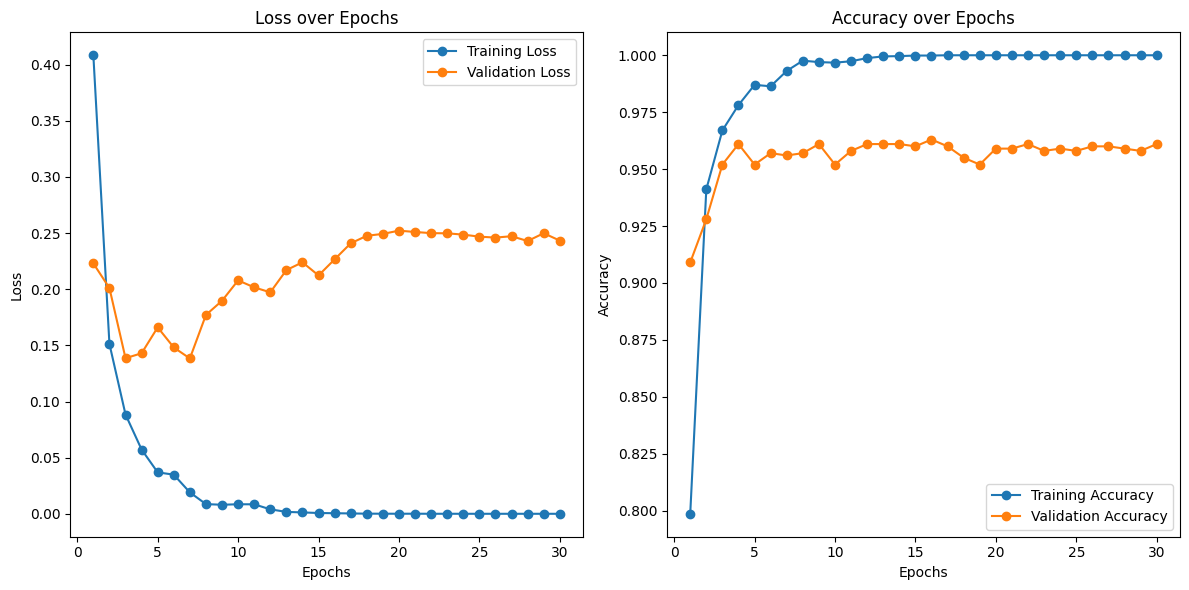

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▆▇▇██████████████████████████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▇█▇▇▇▇█▇▇██████▇▇▇▇█▇▇▇██▇▇█
val_loss,▆▅▁▁▃▂▁▃▄▅▅▅▆▆▆▆▇██████████▇█▇
epoch,30
train_accuracy,1
train_loss,2e-05
val_accuracy,0.961
val_loss,0.24327


In [12]:

!pip install lion-pytorch
from lion_pytorch import Lion
model= load_model_resnet18(pretrained = False, device = device )
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2
                )
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.4
    )
wandb.init(project="gender_classification", name="training_run")
train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch)

có thể thấy với tập dữ liệu chỉ gồm 8 nghìn ảnh và không sử dụng phuơng pháp Augumentation Data thì mô hình overfit khá là nhanh chỉ trong 19 epoch mô hình đã hội tụ về một. Điều này dẫn đến hiện tượng overfit khi mô hình gặp những hình ảnh biến đổi như lật ngang lật dọc, xoay góc, thay đổi độ sáng của ảnh ... thì mô hình sẽ dự đoán không chính xác

### Using transfer Learning with resnet 18

In [13]:
model= load_model_resnet18(pretrained = True, device = device )
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.4
    )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.8MB/s]


In [14]:
# Tính tổng số lượng tham số
total_params = sum(p.numel() for p in model.parameters())

# Tính số lượng tham số cần đóng băng (60%)
percent_to_freeze = 0.6
params_to_freeze = int(percent_to_freeze * total_params)

# Đóng băng các tham số đầu tiên
frozen_params = 0
for param in model.parameters():
    if frozen_params < params_to_freeze:
        param.requires_grad = False
        frozen_params += param.numel()
    else:
        break

wandb: Currently logged in as: 22022597. Use `wandb login --relogin` to force relogin


 10%|█         | 1/10 [00:32<04:54, 32.73s/it]

Epoch 1 / 10 
 Training loss: 0.26163126027584077 - Other training metrics: 
{'accuracy_score': 0.889875, 'f1_score': 0.8898594684641077}
 
 Validation loss : 0.2030696153640747 - Other validation metrics:
{'accuracy_score': 0.926, 'f1_score': 0.9259988159810557}


Validation accuracy= 0.926 ===> Save best epoch


 20%|██        | 2/10 [01:05<04:21, 32.75s/it]

Epoch 2 / 10 
 Training loss: 0.15249845224618913 - Other training metrics: 
{'accuracy_score': 0.941875, 'f1_score': 0.9418745195565758}
 
 Validation loss : 0.17714971387386322 - Other validation metrics:
{'accuracy_score': 0.933, 'f1_score': 0.9329967168391251}


Validation accuracy= 0.933 ===> Save best epoch


 30%|███       | 3/10 [01:38<03:48, 32.69s/it]

Epoch 3 / 10 
 Training loss: 0.12463133955001832 - Other training metrics: 
{'accuracy_score': 0.95325, 'f1_score': 0.9532495061979092}
 
 Validation loss : 0.17559657275676727 - Other validation metrics:
{'accuracy_score': 0.934, 'f1_score': 0.933997623914461}


Validation accuracy= 0.934 ===> Save best epoch


 40%|████      | 4/10 [02:10<03:14, 32.44s/it]

Epoch 4 / 10 
 Training loss: 0.10839532643556594 - Other training metrics: 
{'accuracy_score': 0.956375, 'f1_score': 0.9563749447870394}
 
 Validation loss : 0.17350767827033997 - Other validation metrics:
{'accuracy_score': 0.937, 'f1_score': 0.9369999369999371}


Validation accuracy= 0.937 ===> Save best epoch


 50%|█████     | 5/10 [02:41<02:40, 32.17s/it]

Epoch 5 / 10 
 Training loss: 0.09161441677808761 - Other training metrics: 
{'accuracy_score': 0.966875, 'f1_score': 0.9668742127449623}
 
 Validation loss : 0.1827079484462738 - Other validation metrics:
{'accuracy_score': 0.932, 'f1_score': 0.9319989119825917}


Validation accuracy= 0.932 ===> No saving


 60%|██████    | 6/10 [03:14<02:08, 32.22s/it]

Epoch 6 / 10 
 Training loss: 0.07397218745946885 - Other training metrics: 
{'accuracy_score': 0.97525, 'f1_score': 0.9752499613280645}
 
 Validation loss : 0.2026340436935425 - Other validation metrics:
{'accuracy_score': 0.931, 'f1_score': 0.9309844715060889}


Validation accuracy= 0.931 ===> No saving


 70%|███████   | 7/10 [03:46<01:36, 32.13s/it]

Epoch 7 / 10 
 Training loss: 0.05842857006192207 - Other training metrics: 
{'accuracy_score': 0.98175, 'f1_score': 0.9817499954374989}
 
 Validation loss : 0.2034302718639374 - Other validation metrics:
{'accuracy_score': 0.934, 'f1_score': 0.933999735998944}


Validation accuracy= 0.934 ===> No saving


 80%|████████  | 8/10 [04:18<01:04, 32.23s/it]

Epoch 8 / 10 
 Training loss: 0.041329721480607984 - Other training metrics: 
{'accuracy_score': 0.989125, 'f1_score': 0.989124998470703}
 
 Validation loss : 0.20984917366504668 - Other validation metrics:
{'accuracy_score': 0.934, 'f1_score': 0.933997623914461}


Validation accuracy= 0.934 ===> No saving


 90%|█████████ | 9/10 [04:50<00:32, 32.21s/it]

Epoch 9 / 10 
 Training loss: 0.03858980815112591 - Other training metrics: 
{'accuracy_score': 0.989125, 'f1_score': 0.9891249250639367}
 
 Validation loss : 0.21579762840270997 - Other validation metrics:
{'accuracy_score': 0.932, 'f1_score': 0.931993199319932}


Validation accuracy= 0.932 ===> No saving


100%|██████████| 10/10 [05:23<00:00, 32.35s/it]

Epoch 10 / 10 
 Training loss: 0.029823360353708268 - Other training metrics: 
{'accuracy_score': 0.993625, 'f1_score': 0.9936249919316305}
 
 Validation loss : 0.22313866400718688 - Other validation metrics:
{'accuracy_score': 0.937, 'f1_score': 0.936998424960624}


Validation accuracy= 0.937 ===> No saving


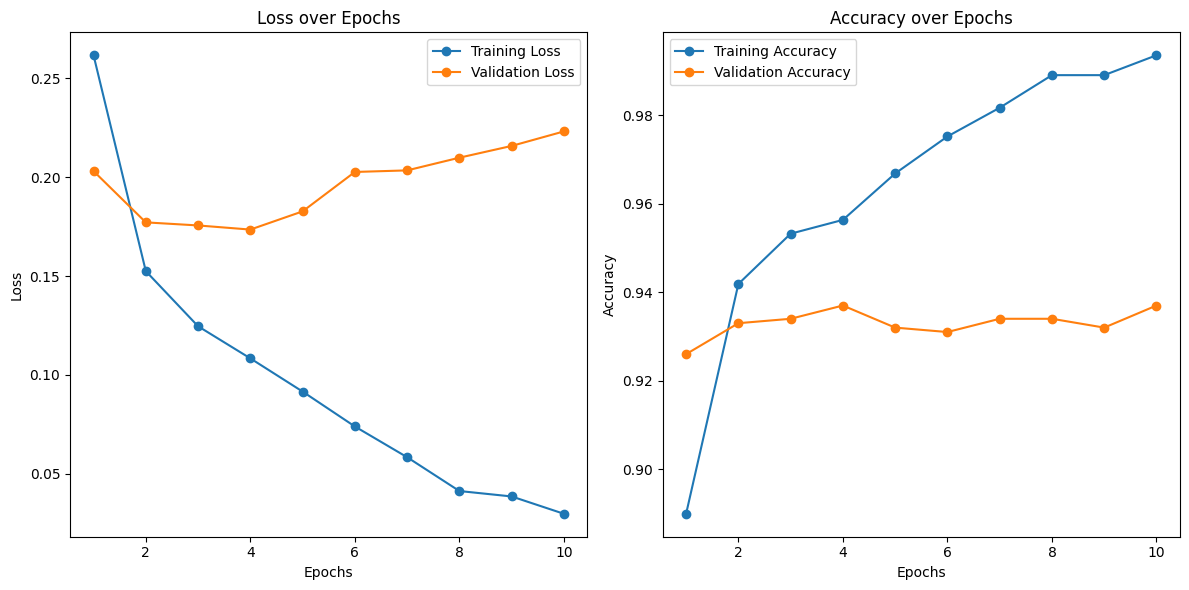

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▅▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▆█▅▄▆▆▅█
val_loss,▅▂▁▁▂▅▅▆▇█
epoch,10
train_accuracy,0.99362
train_loss,0.02982
val_accuracy,0.937
val_loss,0.22314


In [15]:

wandb.init(project="gender_classification", name="training_run pretrained")

train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch=10)

 10%|█         | 1/10 [00:32<04:55, 32.87s/it]

Epoch 1 / 10 
 Training loss: 0.10321492037177085 - Other training metrics: 
{'accuracy_score': 0.964125, 'f1_score': 0.9641248380012215}
 
 Validation loss : 0.10369423580169677 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629955224582174}


Validation accuracy= 0.963 ===> Save best epoch


 20%|██        | 2/10 [01:05<04:22, 32.82s/it]

Epoch 2 / 10 
 Training loss: 0.055718761414289476 - Other training metrics: 
{'accuracy_score': 0.979875, 'f1_score': 0.9798749745292645}
 
 Validation loss : 0.0842331365942955 - Other validation metrics:
{'accuracy_score': 0.967, 'f1_score': 0.9669854405792955}


Validation accuracy= 0.967 ===> Save best epoch


 30%|███       | 3/10 [01:38<03:50, 32.93s/it]

Epoch 3 / 10 
 Training loss: 0.02922072561830282 - Other training metrics: 
{'accuracy_score': 0.989875, 'f1_score': 0.9898749985761717}
 
 Validation loss : 0.06929210531711578 - Other validation metrics:
{'accuracy_score': 0.978, 'f1_score': 0.977999647994368}


Validation accuracy= 0.978 ===> Save best epoch


 40%|████      | 4/10 [02:11<03:17, 32.91s/it]

Epoch 4 / 10 
 Training loss: 0.0200668092854321 - Other training metrics: 
{'accuracy_score': 0.993125, 'f1_score': 0.9931249998925782}
 
 Validation loss : 0.1389696590900421 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.962973007322338}


Validation accuracy= 0.963 ===> No saving


 50%|█████     | 5/10 [02:43<02:43, 32.73s/it]

Epoch 5 / 10 
 Training loss: 0.021409293755888938 - Other training metrics: 
{'accuracy_score': 0.99175, 'f1_score': 0.991749999484375}
 
 Validation loss : 0.1058330955505371 - Other validation metrics:
{'accuracy_score': 0.969, 'f1_score': 0.968999720997489}


Validation accuracy= 0.969 ===> No saving


 60%|██████    | 6/10 [03:16<02:10, 32.62s/it]

Epoch 6 / 10 
 Training loss: 0.016379832319915296 - Other training metrics: 
{'accuracy_score': 0.99425, 'f1_score': 0.994249999640625}
 
 Validation loss : 0.12559254351258278 - Other validation metrics:
{'accuracy_score': 0.974, 'f1_score': 0.9739962554607864}


Validation accuracy= 0.974 ===> No saving


 70%|███████   | 7/10 [03:49<01:38, 32.76s/it]

Epoch 7 / 10 
 Training loss: 0.015072963394690305 - Other training metrics: 
{'accuracy_score': 0.994625, 'f1_score': 0.9946249979003898}
 
 Validation loss : 0.1313802479505539 - Other validation metrics:
{'accuracy_score': 0.973, 'f1_score': 0.9729999729999731}


Validation accuracy= 0.973 ===> No saving


 80%|████████  | 8/10 [04:21<01:05, 32.65s/it]

Epoch 8 / 10 
 Training loss: 0.01821514048334211 - Other training metrics: 
{'accuracy_score': 0.99325, 'f1_score': 0.993249999578125}
 
 Validation loss : 0.08191141217947007 - Other validation metrics:
{'accuracy_score': 0.972, 'f1_score': 0.972}


Validation accuracy= 0.972 ===> No saving


 90%|█████████ | 9/10 [04:54<00:32, 32.65s/it]

Epoch 9 / 10 
 Training loss: 0.014996822900138795 - Other training metrics: 
{'accuracy_score': 0.9945, 'f1_score': 0.9945}
 
 Validation loss : 0.08651062071323395 - Other validation metrics:
{'accuracy_score': 0.969, 'f1_score': 0.968999720997489}


Validation accuracy= 0.969 ===> No saving


100%|██████████| 10/10 [05:26<00:00, 32.69s/it]

Epoch 10 / 10 
 Training loss: 0.012614146967884153 - Other training metrics: 
{'accuracy_score': 0.995625, 'f1_score': 0.9956249999316407}
 
 Validation loss : 0.12525117719173431 - Other validation metrics:
{'accuracy_score': 0.968, 'f1_score': 0.968}


Validation accuracy= 0.968 ===> No saving


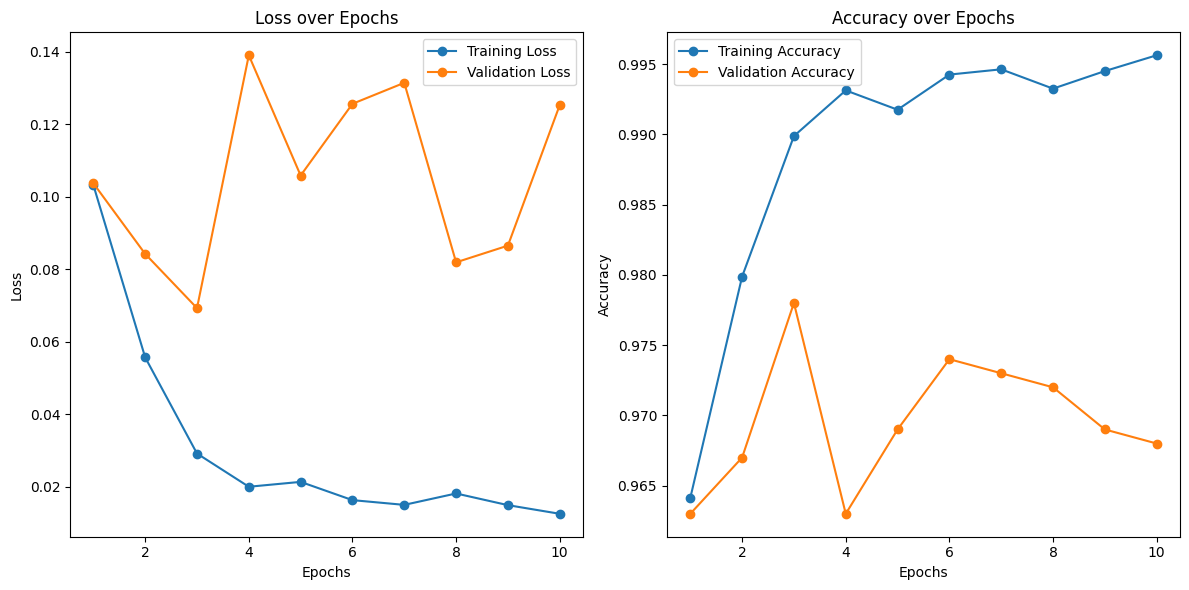

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▇▇██▇██
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▃█▁▄▆▆▅▄▃
val_loss,▄▃▁█▅▇▇▂▃▇
epoch,10
train_accuracy,0.99562
train_loss,0.01261
val_accuracy,0.968
val_loss,0.12525


In [16]:
for param in model.parameters():
    param.requires_grad = True
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
wandb.init(project="gender_classification", name="training_run pretrained")

train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch=10,best_val_acc = 0.939)

## 6.2 Use Agument Data Technical

In [67]:
transformer = transform.Compose([
                           transform.Resize((224, 224)),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(20),
                           transform.RandomAffine(degrees=10, translate=(0.15,0.15), scale=(0.8,1.2)),
                           transform.RandomHorizontalFlip(),
                           transform.ToTensor(),
                           torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])
trainset = ClassificationDataset(data_train,data_path = "",transform=transformer, training=False)
train_loader,_ = make_loader(trainset, train_batch_size=batch_size, validation_split=0.0)
valset = ClassificationDataset(data_val,data_path = "",transform=transformer, training=False)
val_loader,_ = make_loader(valset, train_batch_size=batch_size, validation_split=0.0)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  3%|▎         | 1/30 [00:58<28:20, 58.65s/it]

Epoch 1 / 30 
 Training loss: 0.5654514939785004 - Other training metrics: 
{'accuracy_score': 0.705125, 'f1_score': 0.7048436375857103}
 
 Validation loss : 0.5426390762329102 - Other validation metrics:
{'accuracy_score': 0.767, 'f1_score': 0.7630570320706882}


Validation accuracy= 0.767 ===> Save best epoch


  7%|▋         | 2/30 [01:57<27:24, 58.73s/it]

Epoch 2 / 30 
 Training loss: 0.3626313073635101 - Other training metrics: 
{'accuracy_score': 0.837875, 'f1_score': 0.837830177781481}
 
 Validation loss : 0.2997198073863983 - Other validation metrics:
{'accuracy_score': 0.867, 'f1_score': 0.8669615518884958}


Validation accuracy= 0.867 ===> Save best epoch


 10%|█         | 3/30 [02:57<26:37, 59.15s/it]

Epoch 3 / 30 
 Training loss: 0.2508746926784515 - Other training metrics: 
{'accuracy_score': 0.896875, 'f1_score': 0.8968598367844423}
 
 Validation loss : 0.3406518638134003 - Other validation metrics:
{'accuracy_score': 0.865, 'f1_score': 0.8633159153935641}


Validation accuracy= 0.865 ===> No saving


 13%|█▎        | 4/30 [03:56<25:35, 59.07s/it]

Epoch 4 / 30 
 Training loss: 0.19660218024253845 - Other training metrics: 
{'accuracy_score': 0.92175, 'f1_score': 0.921742560652172}
 
 Validation loss : 0.24918821620941162 - Other validation metrics:
{'accuracy_score': 0.909, 'f1_score': 0.9088153510859489}


Validation accuracy= 0.909 ===> Save best epoch


 17%|█▋        | 5/30 [04:55<24:38, 59.14s/it]

Epoch 5 / 30 
 Training loss: 0.16095375049114227 - Other training metrics: 
{'accuracy_score': 0.934625, 'f1_score': 0.9346186242942847}
 
 Validation loss : 0.1497981470823288 - Other validation metrics:
{'accuracy_score': 0.939, 'f1_score': 0.9389970108535319}


Validation accuracy= 0.939 ===> Save best epoch


 20%|██        | 6/30 [05:53<23:34, 58.94s/it]

Epoch 6 / 30 
 Training loss: 0.13883439373970033 - Other training metrics: 
{'accuracy_score': 0.94625, 'f1_score': 0.946246341391611}
 
 Validation loss : 0.14950354170799254 - Other validation metrics:
{'accuracy_score': 0.95, 'f1_score': 0.9499997999992}


Validation accuracy= 0.95 ===> Save best epoch


 23%|██▎       | 7/30 [06:52<22:34, 58.91s/it]

Epoch 7 / 30 
 Training loss: 0.1254404661655426 - Other training metrics: 
{'accuracy_score': 0.95225, 'f1_score': 0.9522476601353467}
 
 Validation loss : 0.13705264657735824 - Other validation metrics:
{'accuracy_score': 0.951, 'f1_score': 0.9509917176002745}


Validation accuracy= 0.951 ===> Save best epoch


 27%|██▋       | 8/30 [07:51<21:35, 58.87s/it]

Epoch 8 / 30 
 Training loss: 0.10895973294973374 - Other training metrics: 
{'accuracy_score': 0.95775, 'f1_score': 0.9577495537296612}
 
 Validation loss : 0.12251593127846717 - Other validation metrics:
{'accuracy_score': 0.946, 'f1_score': 0.946}


Validation accuracy= 0.946 ===> No saving


 30%|███       | 9/30 [08:50<20:38, 58.98s/it]

Epoch 9 / 30 
 Training loss: 0.10312324321269989 - Other training metrics: 
{'accuracy_score': 0.96125, 'f1_score': 0.9612487187857648}
 
 Validation loss : 0.11423103559017181 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589979909015541}


Validation accuracy= 0.959 ===> Save best epoch


 33%|███▎      | 10/30 [09:50<19:43, 59.19s/it]

Epoch 10 / 30 
 Training loss: 0.09686870181560517 - Other training metrics: 
{'accuracy_score': 0.961, 'f1_score': 0.9609985959494542}
 
 Validation loss : 0.13119329226016999 - Other validation metrics:
{'accuracy_score': 0.954, 'f1_score': 0.953999815999264}


Validation accuracy= 0.954 ===> No saving


 37%|███▋      | 11/30 [10:50<18:48, 59.39s/it]

Epoch 11 / 30 
 Training loss: 0.08854089337587356 - Other training metrics: 
{'accuracy_score': 0.966125, 'f1_score': 0.9661247199996388}
 
 Validation loss : 0.10952058786153793 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629981869111586}


Validation accuracy= 0.963 ===> Save best epoch


 40%|████      | 12/30 [11:51<18:01, 60.06s/it]

Epoch 12 / 30 
 Training loss: 0.08163941317796707 - Other training metrics: 
{'accuracy_score': 0.969125, 'f1_score': 0.9691245942778717}
 
 Validation loss : 0.12073614954948425 - Other validation metrics:
{'accuracy_score': 0.954, 'f1_score': 0.9539850911695389}


Validation accuracy= 0.954 ===> No saving


 43%|████▎     | 13/30 [12:52<17:04, 60.25s/it]

Epoch 13 / 30 
 Training loss: 0.08168095400929451 - Other training metrics: 
{'accuracy_score': 0.9675, 'f1_score': 0.9674993418616727}
 
 Validation loss : 0.1277127143740654 - Other validation metrics:
{'accuracy_score': 0.953, 'f1_score': 0.9529706066291432}


Validation accuracy= 0.953 ===> No saving


 47%|████▋     | 14/30 [13:52<16:04, 60.28s/it]

Epoch 14 / 30 
 Training loss: 0.07863660570979118 - Other training metrics: 
{'accuracy_score': 0.969875, 'f1_score': 0.96987460413347}
 
 Validation loss : 0.10186773920059204 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629999629999629}


Validation accuracy= 0.963 ===> No saving


 50%|█████     | 15/30 [14:52<15:03, 60.21s/it]

Epoch 15 / 30 
 Training loss: 0.07166426506638526 - Other training metrics: 
{'accuracy_score': 0.97275, 'f1_score': 0.9727499574218086}
 
 Validation loss : 0.17709431153535843 - Other validation metrics:
{'accuracy_score': 0.936, 'f1_score': 0.9358869044995373}


Validation accuracy= 0.936 ===> No saving


 53%|█████▎    | 16/30 [15:51<13:58, 59.87s/it]

Epoch 16 / 30 
 Training loss: 0.07298331862688065 - Other training metrics: 
{'accuracy_score': 0.97325, 'f1_score': 0.9732498645774394}
 
 Validation loss : 0.12577148282527922 - Other validation metrics:
{'accuracy_score': 0.955, 'f1_score': 0.9549898727213622}


Validation accuracy= 0.955 ===> No saving


 57%|█████▋    | 17/30 [16:51<12:57, 59.82s/it]

Epoch 17 / 30 
 Training loss: 0.073076714605093 - Other training metrics: 
{'accuracy_score': 0.971625, 'f1_score': 0.9716247228976845}
 
 Validation loss : 0.0914445376098156 - Other validation metrics:
{'accuracy_score': 0.971, 'f1_score': 0.9709976508097156}


Validation accuracy= 0.971 ===> Save best epoch


 60%|██████    | 18/30 [17:50<11:55, 59.62s/it]

Epoch 18 / 30 
 Training loss: 0.06663840916752815 - Other training metrics: 
{'accuracy_score': 0.972625, 'f1_score': 0.9726248113678408}
 
 Validation loss : 0.11572455328702927 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.9579917663862116}


Validation accuracy= 0.958 ===> No saving


 63%|██████▎   | 19/30 [18:51<10:59, 59.97s/it]

Epoch 19 / 30 
 Training loss: 0.061737795501947405 - Other training metrics: 
{'accuracy_score': 0.9755, 'f1_score': 0.9754999862187421}
 
 Validation loss : 0.11665098005533218 - Other validation metrics:
{'accuracy_score': 0.958, 'f1_score': 0.957998487945566}


Validation accuracy= 0.958 ===> No saving


 67%|██████▋   | 20/30 [19:50<09:56, 59.65s/it]

Epoch 20 / 30 
 Training loss: 0.055837259337306024 - Other training metrics: 
{'accuracy_score': 0.98, 'f1_score': 0.97999991999968}
 
 Validation loss : 0.10042845803499222 - Other validation metrics:
{'accuracy_score': 0.965, 'f1_score': 0.9649982849159608}


Validation accuracy= 0.965 ===> No saving


 70%|███████   | 21/30 [20:49<08:56, 59.59s/it]

Epoch 21 / 30 
 Training loss: 0.055186048820614814 - Other training metrics: 
{'accuracy_score': 0.979375, 'f1_score': 0.9793749455369656}
 
 Validation loss : 0.10493125593662261 - Other validation metrics:
{'accuracy_score': 0.959, 'f1_score': 0.9589950383996464}


Validation accuracy= 0.959 ===> No saving


 73%|███████▎  | 22/30 [21:48<07:54, 59.37s/it]

Epoch 22 / 30 
 Training loss: 0.04629291465133428 - Other training metrics: 
{'accuracy_score': 0.98225, 'f1_score': 0.9822499456404585}
 
 Validation loss : 0.09929024505615235 - Other validation metrics:
{'accuracy_score': 0.969, 'f1_score': 0.9689947601144594}


Validation accuracy= 0.969 ===> No saving


 77%|███████▋  | 23/30 [22:47<06:54, 59.27s/it]

Epoch 23 / 30 
 Training loss: 0.044672202698886394 - Other training metrics: 
{'accuracy_score': 0.982625, 'f1_score': 0.9826249997285157}
 
 Validation loss : 0.08027580851316451 - Other validation metrics:
{'accuracy_score': 0.971, 'f1_score': 0.970999970999971}


Validation accuracy= 0.971 ===> No saving


 80%|████████  | 24/30 [23:48<05:57, 59.55s/it]

Epoch 24 / 30 
 Training loss: 0.0359969275072217 - Other training metrics: 
{'accuracy_score': 0.987625, 'f1_score': 0.9876249147279281}
 
 Validation loss : 0.11121019887924194 - Other validation metrics:
{'accuracy_score': 0.962, 'f1_score': 0.961999847999392}


Validation accuracy= 0.962 ===> No saving


 83%|████████▎ | 25/30 [24:48<04:58, 59.71s/it]

Epoch 25 / 30 
 Training loss: 0.03418444426357746 - Other training metrics: 
{'accuracy_score': 0.98775, 'f1_score': 0.987749999234375}
 
 Validation loss : 0.10906472384929657 - Other validation metrics:
{'accuracy_score': 0.968, 'f1_score': 0.9679988479585264}


Validation accuracy= 0.968 ===> No saving


 87%|████████▋ | 26/30 [25:48<04:00, 60.04s/it]

Epoch 26 / 30 
 Training loss: 0.032442544374614954 - Other training metrics: 
{'accuracy_score': 0.987375, 'f1_score': 0.987374990333977}
 
 Validation loss : 0.14063639521598817 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629990749768744}


Validation accuracy= 0.963 ===> No saving


 90%|█████████ | 27/30 [26:48<02:59, 59.87s/it]

Epoch 27 / 30 
 Training loss: 0.025585776768624783 - Other training metrics: 
{'accuracy_score': 0.990125, 'f1_score': 0.990124965283081}
 
 Validation loss : 0.10686833095550537 - Other validation metrics:
{'accuracy_score': 0.966, 'f1_score': 0.9659978238607271}


Validation accuracy= 0.966 ===> No saving


 93%|█████████▎| 28/30 [27:48<01:59, 59.84s/it]

Epoch 28 / 30 
 Training loss: 0.022774773642420768 - Other training metrics: 
{'accuracy_score': 0.991875, 'f1_score': 0.9918749897167839}
 
 Validation loss : 0.1172098729610443 - Other validation metrics:
{'accuracy_score': 0.973, 'f1_score': 0.9729997569978129}


Validation accuracy= 0.973 ===> Save best epoch


 97%|█████████▋| 29/30 [28:47<00:59, 59.66s/it]

Epoch 29 / 30 
 Training loss: 0.022762590058147906 - Other training metrics: 
{'accuracy_score': 0.992, 'f1_score': 0.991999991999992}
 
 Validation loss : 0.10640605849027633 - Other validation metrics:
{'accuracy_score': 0.969, 'f1_score': 0.9689984809255654}


Validation accuracy= 0.969 ===> No saving


100%|██████████| 30/30 [29:46<00:00, 59.55s/it]

Epoch 30 / 30 
 Training loss: 0.023472107335925103 - Other training metrics: 
{'accuracy_score': 0.99175, 'f1_score': 0.991749999484375}
 
 Validation loss : 0.10343744644522666 - Other validation metrics:
{'accuracy_score': 0.969, 'f1_score': 0.9689999689999689}


Validation accuracy= 0.969 ===> No saving


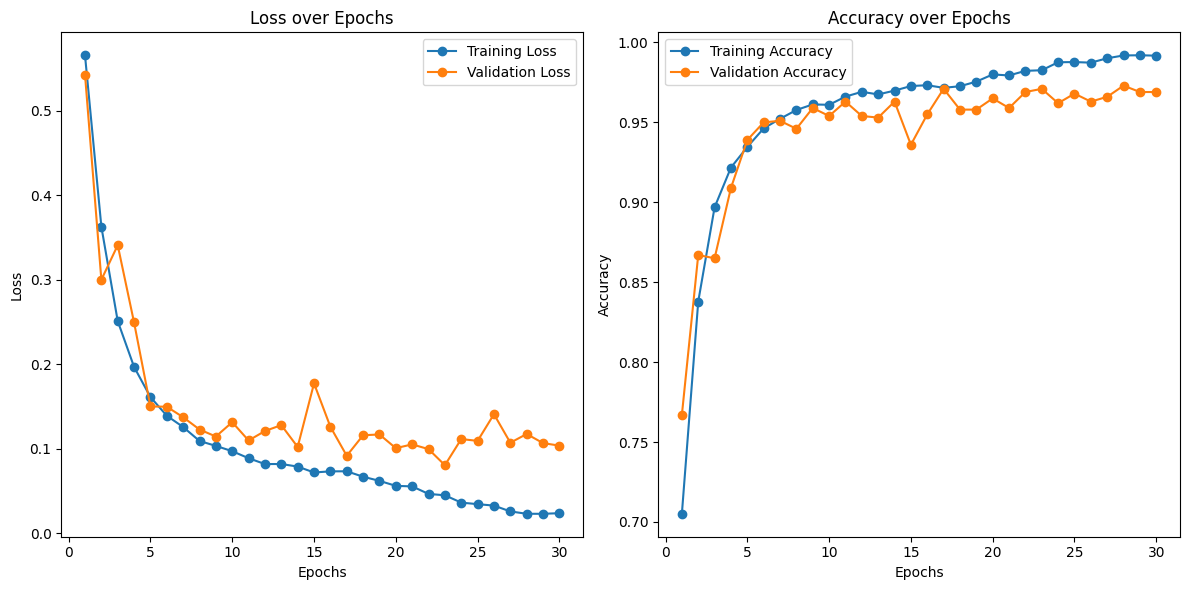

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇████████████████
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▇▇▇▇█▇█▇▇█▇▇█▇▇███████████
val_loss,█▄▅▄▂▂▂▂▂▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁
epoch,30
train_accuracy,0.99175
train_loss,0.02347
val_accuracy,0.969
val_loss,0.10344


In [18]:
model= load_model_resnet18(pretrained = False, device = device )
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2
                )
# optimizer = torch.optim.Adam(model.parameters(), 1e-4)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.4
    )
wandb.init(project="gender_classification", name="training_run")
train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch)

su dung model resnet 18 pretrained = True voi data duoc aggument moi 

In [68]:
model= load_model_resnet18(pretrained = True, device = device )
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.4
    )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
# Tính tổng số lượng tham số
total_params = sum(p.numel() for p in model.parameters())

# Tính số lượng tham số cần đóng băng (60%)
percent_to_freeze = 0.6
params_to_freeze = int(percent_to_freeze * total_params)

# Đóng băng các tham số đầu tiên
frozen_params = 0
for param in model.parameters():
    if frozen_params < params_to_freeze:
        param.requires_grad = False
        frozen_params += param.numel()
    else:
        break

 10%|█         | 1/10 [01:09<10:27, 69.71s/it]

Epoch 1 / 10 
 Training loss: 0.3011842021942139 - Other training metrics: 
{'accuracy_score': 0.873875, 'f1_score': 0.8738749034354729}
 
 Validation loss : 0.23127138257026672 - Other validation metrics:
{'accuracy_score': 0.917, 'f1_score': 0.9169899557846499}


Validation accuracy= 0.917 ===> Save best epoch


 20%|██        | 2/10 [02:07<08:21, 62.74s/it]

Epoch 2 / 10 
 Training loss: 0.22360654497146606 - Other training metrics: 
{'accuracy_score': 0.90925, 'f1_score': 0.9092490414430002}
 
 Validation loss : 0.21543981099128723 - Other validation metrics:
{'accuracy_score': 0.912, 'f1_score': 0.9119985919774716}


Validation accuracy= 0.912 ===> No saving


 30%|███       | 3/10 [03:06<07:06, 60.96s/it]

Epoch 3 / 10 
 Training loss: 0.19709605133533478 - Other training metrics: 
{'accuracy_score': 0.9195, 'f1_score': 0.9194979874496862}
 
 Validation loss : 0.1982504699230194 - Other validation metrics:
{'accuracy_score': 0.926, 'f1_score': 0.9259973359040925}


Validation accuracy= 0.926 ===> Save best epoch


 40%|████      | 4/10 [04:04<05:59, 59.92s/it]

Epoch 4 / 10 
 Training loss: 0.19018350446224214 - Other training metrics: 
{'accuracy_score': 0.92375, 'f1_score': 0.9237499571093508}
 
 Validation loss : 0.2205791035890579 - Other validation metrics:
{'accuracy_score': 0.914, 'f1_score': 0.913999655998624}


Validation accuracy= 0.914 ===> No saving


 50%|█████     | 5/10 [05:04<04:58, 59.77s/it]

Epoch 5 / 10 
 Training loss: 0.18319302654266356 - Other training metrics: 
{'accuracy_score': 0.92375, 'f1_score': 0.9237467783013833}
 
 Validation loss : 0.1808597310781479 - Other validation metrics:
{'accuracy_score': 0.931, 'f1_score': 0.9309999309999311}


Validation accuracy= 0.931 ===> Save best epoch


 60%|██████    | 6/10 [06:03<03:58, 59.73s/it]

Epoch 6 / 10 
 Training loss: 0.17947006702423096 - Other training metrics: 
{'accuracy_score': 0.926625, 'f1_score': 0.9266201557837217}
 
 Validation loss : 0.19166524243354796 - Other validation metrics:
{'accuracy_score': 0.934, 'f1_score': 0.933999735998944}


Validation accuracy= 0.934 ===> Save best epoch


 70%|███████   | 7/10 [07:02<02:57, 59.27s/it]

Epoch 7 / 10 
 Training loss: 0.17922848731279373 - Other training metrics: 
{'accuracy_score': 0.92775, 'f1_score': 0.9277485369078724}
 
 Validation loss : 0.19114748978614807 - Other validation metrics:
{'accuracy_score': 0.928, 'f1_score': 0.9279766644392783}


Validation accuracy= 0.928 ===> No saving


 80%|████████  | 8/10 [08:00<01:57, 58.99s/it]

Epoch 8 / 10 
 Training loss: 0.1695846208333969 - Other training metrics: 
{'accuracy_score': 0.932875, 'f1_score': 0.9328705684086176}
 
 Validation loss : 0.20476049041748046 - Other validation metrics:
{'accuracy_score': 0.933, 'f1_score': 0.932999932999933}


Validation accuracy= 0.933 ===> No saving


 90%|█████████ | 9/10 [09:00<00:59, 59.22s/it]

Epoch 9 / 10 
 Training loss: 0.1597641485929489 - Other training metrics: 
{'accuracy_score': 0.935875, 'f1_score': 0.9358696601471705}
 
 Validation loss : 0.21029554319381713 - Other validation metrics:
{'accuracy_score': 0.916, 'f1_score': 0.9159835327724235}


Validation accuracy= 0.916 ===> No saving


100%|██████████| 10/10 [09:59<00:00, 59.90s/it]

Epoch 10 / 10 
 Training loss: 0.16747672921419143 - Other training metrics: 
{'accuracy_score': 0.934, 'f1_score': 0.9339990718619481}
 
 Validation loss : 0.18279943132400514 - Other validation metrics:
{'accuracy_score': 0.927, 'f1_score': 0.926999926999927}


Validation accuracy= 0.927 ===> No saving


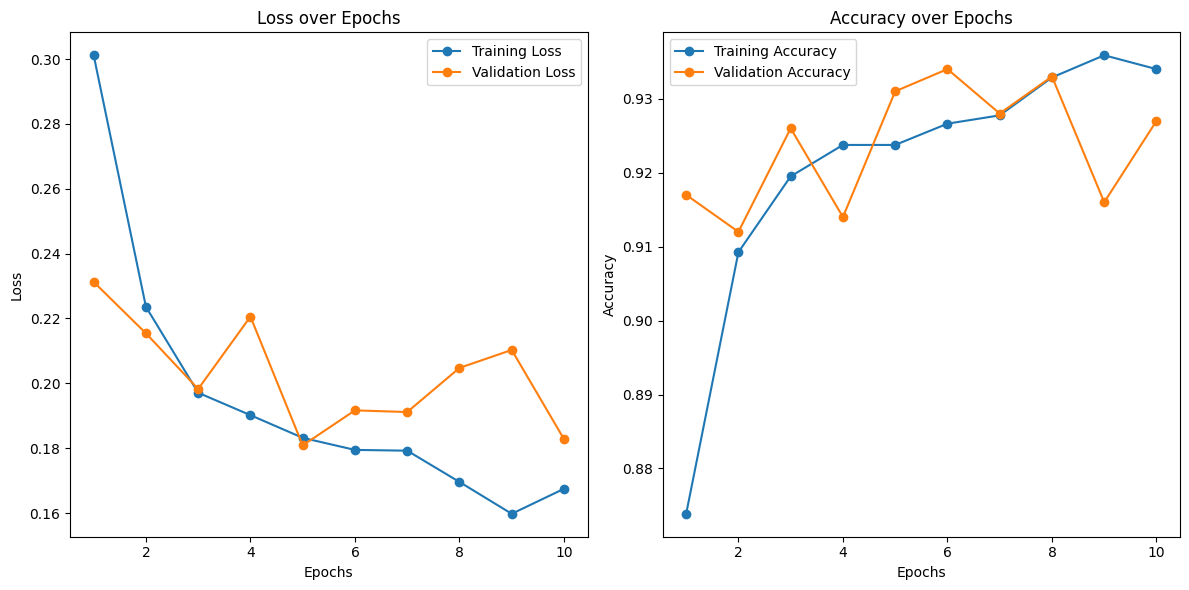

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▃▁▅▂▇█▆█▂▆
val_loss,█▆▃▇▁▃▂▄▅▁
epoch,10
train_accuracy,0.934
train_loss,0.16748
val_accuracy,0.927
val_loss,0.1828


In [70]:

wandb.init(project="gender_classification", name="training_run pretrained")

train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch=10)

  5%|▌         | 1/20 [00:59<18:57, 59.87s/it]

Epoch 1 / 20 
 Training loss: 0.12858060830831528 - Other training metrics: 
{'accuracy_score': 0.950875, 'f1_score': 0.9508745939478156}
 
 Validation loss : 0.11335672822594643 - Other validation metrics:
{'accuracy_score': 0.948, 'f1_score': 0.9479981279326055}


Validation accuracy= 0.948 ===> Save best epoch


 10%|█         | 2/20 [02:00<18:01, 60.06s/it]

Epoch 2 / 20 
 Training loss: 0.07792039106786251 - Other training metrics: 
{'accuracy_score': 0.969875, 'f1_score': 0.9698746568535133}
 
 Validation loss : 0.09937636452913284 - Other validation metrics:
{'accuracy_score': 0.962, 'f1_score': 0.962}


Validation accuracy= 0.962 ===> Save best epoch


 15%|█▌        | 3/20 [02:59<16:52, 59.58s/it]

Epoch 3 / 20 
 Training loss: 0.06167298705875873 - Other training metrics: 
{'accuracy_score': 0.97775, 'f1_score': 0.9777498609366309}
 
 Validation loss : 0.09674712523818016 - Other validation metrics:
{'accuracy_score': 0.963, 'f1_score': 0.9629893039088295}


Validation accuracy= 0.963 ===> Save best epoch


 20%|██        | 4/20 [03:58<15:49, 59.35s/it]

Epoch 4 / 20 
 Training loss: 0.05093330037593841 - Other training metrics: 
{'accuracy_score': 0.981875, 'f1_score': 0.9818749929199191}
 
 Validation loss : 0.08435062843561172 - Other validation metrics:
{'accuracy_score': 0.971, 'f1_score': 0.9709950981715909}


Validation accuracy= 0.971 ===> Save best epoch


 25%|██▌       | 5/20 [04:57<14:51, 59.46s/it]

Epoch 5 / 20 
 Training loss: 0.04314633407443762 - Other training metrics: 
{'accuracy_score': 0.984125, 'f1_score': 0.9841249878456939}
 
 Validation loss : 0.10080419427156448 - Other validation metrics:
{'accuracy_score': 0.968, 'f1_score': 0.9679896286396793}


Validation accuracy= 0.968 ===> No saving


 30%|███       | 6/20 [05:57<13:54, 59.60s/it]

Epoch 6 / 20 
 Training loss: 0.04023597083240747 - Other training metrics: 
{'accuracy_score': 0.985375, 'f1_score': 0.9853749613807574}
 
 Validation loss : 0.10248599362373352 - Other validation metrics:
{'accuracy_score': 0.965, 'f1_score': 0.9649996849971649}


Validation accuracy= 0.965 ===> No saving


 35%|███▌      | 7/20 [06:58<12:59, 59.97s/it]

Epoch 7 / 20 
 Training loss: 0.03287765756249428 - Other training metrics: 
{'accuracy_score': 0.987875, 'f1_score': 0.9878749846542775}
 
 Validation loss : 0.09926745280623436 - Other validation metrics:
{'accuracy_score': 0.964, 'f1_score': 0.9639948152533965}


Validation accuracy= 0.964 ===> No saving


 40%|████      | 8/20 [07:57<11:57, 59.79s/it]

Epoch 8 / 20 
 Training loss: 0.02305707674100995 - Other training metrics: 
{'accuracy_score': 0.9915, 'f1_score': 0.9914999867187293}
 
 Validation loss : 0.08841544097661971 - Other validation metrics:
{'accuracy_score': 0.972, 'f1_score': 0.971999551992832}


Validation accuracy= 0.972 ===> Save best epoch


 45%|████▌     | 9/20 [08:57<10:57, 59.74s/it]

Epoch 9 / 20 
 Training loss: 0.021364015903323888 - Other training metrics: 
{'accuracy_score': 0.99275, 'f1_score': 0.9927499959218729}
 
 Validation loss : 0.10366392731666565 - Other validation metrics:
{'accuracy_score': 0.972, 'f1_score': 0.9719989919637106}


Validation accuracy= 0.972 ===> No saving


 50%|█████     | 10/20 [09:57<09:59, 59.96s/it]

Epoch 10 / 20 
 Training loss: 0.018431444635614753 - Other training metrics: 
{'accuracy_score': 0.99375, 'f1_score': 0.9937499984374996}
 
 Validation loss : 0.08066059079021215 - Other validation metrics:
{'accuracy_score': 0.983, 'f1_score': 0.9829995749893746}


Validation accuracy= 0.983 ===> Save best epoch


 55%|█████▌    | 11/20 [10:57<08:58, 59.82s/it]

Epoch 11 / 20 
 Training loss: 0.021776037523522973 - Other training metrics: 
{'accuracy_score': 0.992375, 'f1_score': 0.9923749989277342}
 
 Validation loss : 0.06884925639629363 - Other validation metrics:
{'accuracy_score': 0.98, 'f1_score': 0.98}


Validation accuracy= 0.98 ===> No saving


 60%|██████    | 12/20 [11:58<08:01, 60.20s/it]

Epoch 12 / 20 
 Training loss: 0.015436758352443576 - Other training metrics: 
{'accuracy_score': 0.994375, 'f1_score': 0.9943749992089843}
 
 Validation loss : 0.07998245978355407 - Other validation metrics:
{'accuracy_score': 0.974, 'f1_score': 0.9739973997399739}


Validation accuracy= 0.974 ===> No saving


 65%|██████▌   | 13/20 [12:59<07:03, 60.51s/it]

Epoch 13 / 20 
 Training loss: 0.01373862178158015 - Other training metrics: 
{'accuracy_score': 0.99475, 'f1_score': 0.99475}
 
 Validation loss : 0.07555851963162422 - Other validation metrics:
{'accuracy_score': 0.981, 'f1_score': 0.9809998289984609}


Validation accuracy= 0.981 ===> No saving


 70%|███████   | 14/20 [13:59<06:02, 60.47s/it]

Epoch 14 / 20 
 Training loss: 0.012919168365187942 - Other training metrics: 
{'accuracy_score': 0.99575, 'f1_score': 0.9957499989374997}
 
 Validation loss : 0.08993639409542084 - Other validation metrics:
{'accuracy_score': 0.974, 'f1_score': 0.9739995839933439}


Validation accuracy= 0.974 ===> No saving


 75%|███████▌  | 15/20 [15:03<05:06, 61.28s/it]

Epoch 15 / 20 
 Training loss: 0.011089379525743424 - Other training metrics: 
{'accuracy_score': 0.996625, 'f1_score': 0.9966249999472656}
 
 Validation loss : 0.08050542366504669 - Other validation metrics:
{'accuracy_score': 0.977, 'f1_score': 0.976999976999977}


Validation accuracy= 0.977 ===> No saving


 80%|████████  | 16/20 [16:03<04:04, 61.04s/it]

Epoch 16 / 20 
 Training loss: 0.010033988563460298 - Other training metrics: 
{'accuracy_score': 0.99725, 'f1_score': 0.997249999828125}
 
 Validation loss : 0.08553460872173309 - Other validation metrics:
{'accuracy_score': 0.975, 'f1_score': 0.974999774997975}


Validation accuracy= 0.975 ===> No saving


 85%|████████▌ | 17/20 [17:04<03:03, 61.10s/it]

Epoch 17 / 20 
 Training loss: 0.007844856749288738 - Other training metrics: 
{'accuracy_score': 0.99675, 'f1_score': 0.9967499967499966}
 
 Validation loss : 0.08600351816415787 - Other validation metrics:
{'accuracy_score': 0.974, 'f1_score': 0.9739995839933439}


Validation accuracy= 0.974 ===> No saving


 90%|█████████ | 18/20 [18:06<02:02, 61.22s/it]

Epoch 18 / 20 
 Training loss: 0.007464985692873597 - Other training metrics: 
{'accuracy_score': 0.99725, 'f1_score': 0.99725}
 
 Validation loss : 0.10008484698832035 - Other validation metrics:
{'accuracy_score': 0.976, 'f1_score': 0.9759991359688949}


Validation accuracy= 0.976 ===> No saving


 95%|█████████▌| 19/20 [19:06<01:00, 60.83s/it]

Epoch 19 / 20 
 Training loss: 0.005611036788905039 - Other training metrics: 
{'accuracy_score': 0.997125, 'f1_score': 0.9971249999550781}
 
 Validation loss : 0.08285094600915908 - Other validation metrics:
{'accuracy_score': 0.978, 'f1_score': 0.977999207971487}


Validation accuracy= 0.978 ===> No saving


100%|██████████| 20/20 [20:06<00:00, 60.30s/it]

Epoch 20 / 20 
 Training loss: 0.0045064636826282365 - Other training metrics: 
{'accuracy_score': 0.998875, 'f1_score': 0.9988749998417968}
 
 Validation loss : 0.08713177520036697 - Other validation metrics:
{'accuracy_score': 0.972, 'f1_score': 0.9719998879995521}


Validation accuracy= 0.972 ===> No saving


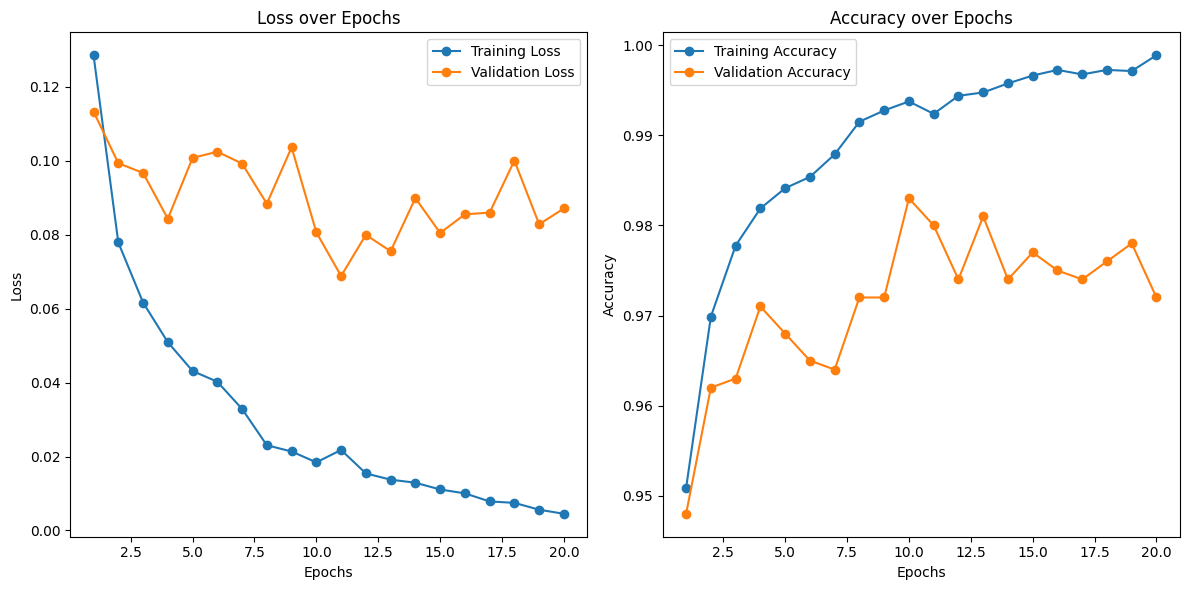

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▄▆▅▄▄▆▆█▇▆█▆▇▆▆▇▇▆
val_loss,█▆▅▃▆▆▆▄▆▃▁▃▂▄▃▄▄▆▃▄
epoch,20
train_accuracy,0.99887
train_loss,0.00451
val_accuracy,0.972
val_loss,0.08713


In [71]:
for param in model.parameters():
    param.requires_grad = True
# optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
wandb.init(project="gender_classification", name="training_run pretrained")

train(model, train_loader,val_loader, device, optimizer, criterion, train_metrics, val_metrics,num_epoch=20,best_val_acc = 0.939)

# 7. Test-Time Augmentation

## 7.1 Dự đoán trên tập test không sự dụng phương pháp Test-Time Augumentation

Tập Test do em tự chia trên tập public test và  quan sát thì có khoảng 500 ảnh là Male và 500 ảnh là Female với sai số khoảng 2-3 ảnh 

In [72]:
transformer = transform.Compose([
                           transform.Resize((224, 224)),
                           transform.ToTensor(),
                           torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])
                                     ])
testset = ClassificationDataset(data_test,data_path = "",transform=transformer, training=False)
test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False,
    )

In [73]:
def test_result(model, test_loader, device):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            target = target.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())
    return labels,preds

In [107]:
labels,preds =test_result(model, test_loader, device)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_label = ['Male', 'Female']
report = classification_report(labels, preds, digits=4,target_names=class_label)

cm = confusion_matrix(labels, preds)

In [91]:
print(report)

              precision    recall  f1-score   support

        Male     0.9919    0.9840    0.9880       500
      Female     0.9841    0.9920    0.9880       500

    accuracy                         0.9880      1000
   macro avg     0.9880    0.9880    0.9880      1000
weighted avg     0.9880    0.9880    0.9880      1000



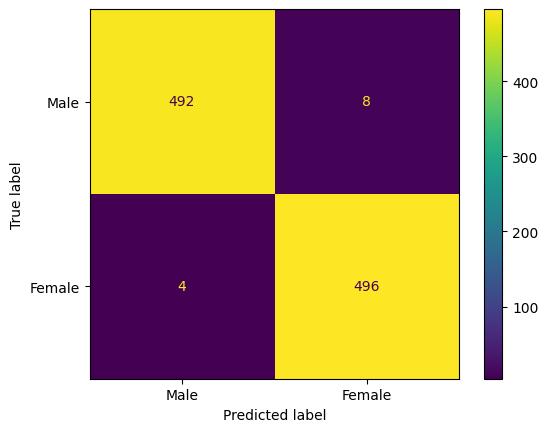

In [76]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot()

## 7.2 Sử dụng phương pháp Test-time Augmentation

###
### Có thể thấy bằng việc sử dụng phuơng pháp Test-Time Augmentation thì độ chính xác của mô hình đã được cải thiện một cách đáng kể 
### Phuơng pháp test-time Augmentation là một phương pháp được sử dụng để tăng độ chính xác của mô hình trong quá trình dự đoán : 
### +) bằng việc từ một ảnh dự đoán ban đầu ta sẽ sinh ra các ảnh mới từ ảnh cũ bằng cách lật, xoay, tăng giảm độ sáng của ảnh
### +) Từ các ảnh mới ta sẽ đưa các ảnh này đi qua mô hình của chúng ta
### +) kết quả sẽ được tính bằng cách lấy trung bình giá trị của các ảnh này để đưa ra kết quả cuối cùng
### +) Với phương pháp này mô hình sẽ dự đoán từ nhiều góc nhìn khác nhau.

In [77]:
!pip install ttach

In [78]:
import ttach as tta

In [79]:
test_model = torch.load("best.pt")

/tmp/ipykernel_23/462319776.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model = torch.load("best.pt")


In [226]:
# Define TTA augmentations
transforms = tta.Compose([
    tta.HorizontalFlip(),
    # tta.Rotate90(angles=[-20, 0, 20]),
    # tta.Scale(scales=[0.8, 1, 1.2]),  # Slight scaling
    tta.Multiply(factors=[0.7, 1, 1.3]),  # Brightness adjustments
    # tta.FiveCrops(190, 190)  # Crops the image into 5 different sizes
])

tta_model = tta.ClassificationTTAWrapper(test_model, transforms)

In [227]:
device = torch.device("cuda")
import torch.nn as nn
labels,preds =test_result(tta_model, test_loader, device)

In [228]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_label = ['Male', 'Female']
report = classification_report(labels, preds, digits=4,target_names=class_label)

cm = confusion_matrix(labels, preds)

In [229]:
print(report)

              precision    recall  f1-score   support

        Male     0.9880    0.9860    0.9870       500
      Female     0.9860    0.9880    0.9870       500

    accuracy                         0.9870      1000
   macro avg     0.9870    0.9870    0.9870      1000
weighted avg     0.9870    0.9870    0.9870      1000



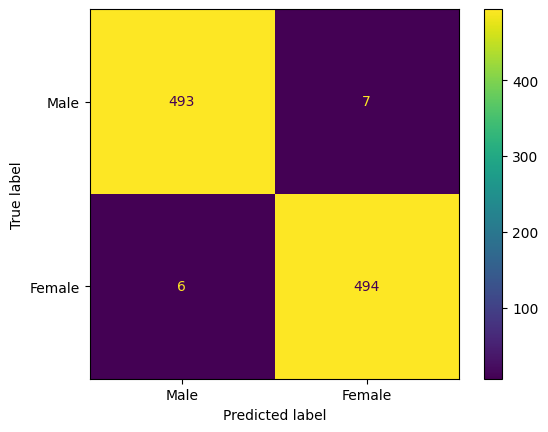

In [230]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_label)
disp.plot()

 Phuơng pháp Test-Time Augmentation trong đa phần nhưng lần chạy thì độ chính xác của mô hình đã được cải thiện 

In [231]:
import re
id = data_test.path.apply(lambda x: re.search(r"\d+", x).group())

result = pd.DataFrame({"ID":id, "preds":preds})
# convert value: 0 -> 1, 1 -> 0
result['preds'] = result['preds'].apply(lambda x: 1 if x == 0 else 0)

# save to file cvs
result.to_csv("result.csv",index=False)